<font size=6> Report 3 - STA 6908 <font> <br>
Mina Akhondzadeh

From the Amazon review large dataset we have selected the topics below to combine. I was looking for categories which will introduce the most variation in topic, tone and sentiment.

- Beauty_and_Personal_Care 
- Books 
- Electronics 
- Grocery_and_Gourmet_Food 
- Toys_and_Games 
- Office_Products 

In [97]:
import pandas as pd
import numpy as np

categories = ["Beauty_and_Personal_Care", "Books", "Electronics", "Grocery_and_Gourmet_Food", "Toys_and_Games", "Office_Products"]
chunksize = 5000
reviews = pd.DataFrame()

for category in categories:
    file = f"{category}.jsonl"
    json_reader = pd.read_json(file, lines=True, chunksize=chunksize)
    df = next(json_reader)[["title", "text"]]
    df["category"] = category

    reviews = pd.concat([reviews, df], axis=0)

reviews.reset_index(drop=True, inplace=True)

# Combine text and title
reviews["text"] = reviews["title"] + reviews["text"]
reviews.drop("title", axis=1, inplace=True)

# Shuffle samples
reviews = reviews.sample(frac=1, random_state=22).reset_index(drop=True)

reviews.head()

,text,category
0,WorksDoesn’t smell fantastic buy definitely works,Beauty_and_Personal_Care
1,"Sturdy!These are sturdy, poly plastic folder/d...",Office_Products
2,I really like this product.At 74 nothing makes...,Beauty_and_Personal_Care
3,"Great value, big box.This 58 count box is such...",Grocery_and_Gourmet_Food
4,Scholarly Monograph About “Bioinformation”BIOI...,Books


# STEP 1.1: TF-IDF + Logistic Regression

Accuracy of Train Set: 0.87
Accuracy of Logistic Regression Model: 0.84


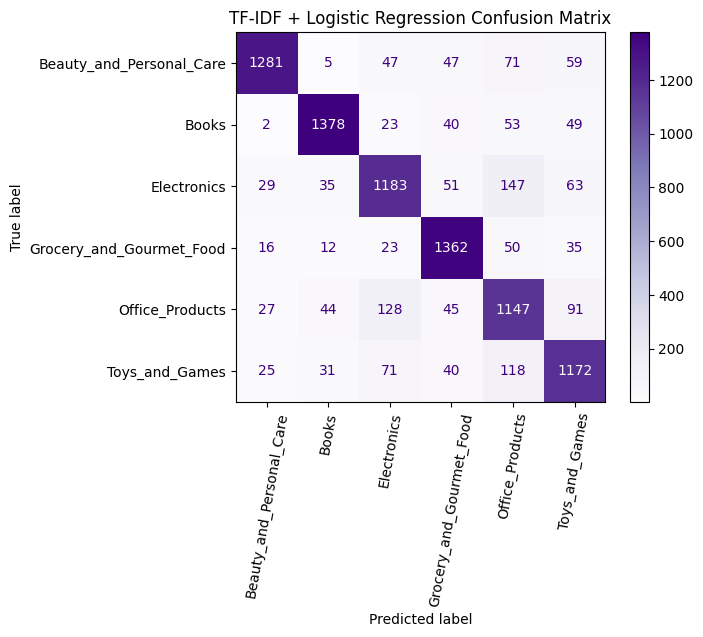

In [17]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)

processed_texts = tfid.fit_transform(reviews["text"])

# Train-Test
from sklearn.model_selection import train_test_split

X = processed_texts
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Fit regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="multinomial", solver="saga",
                           penalty="elasticnet", l1_ratio=0.5, C=1)

model.fit(X_train, y_train)
y_test_df = pd.DataFrame()
y_test_df["true_value"] = y_test

y_test_df["logistic_regression"] = model.predict(X_test)

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["logistic_regression"],
                      labels=np.unique(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)

import matplotlib.pyplot as plt
plt.title("TF-IDF + Logistic Regression Confusion Matrix")


# Accuracy
accuracy_df = pd.DataFrame(columns=["model", "set", "accuracy"])


# Train Accuracy to check overfitting
y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)
print(f"Accuracy of Train Set: {accuracy_train:.2f}")

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["logistic_regression"])
print(f"Accuracy of Logistic Regression Model: {accuracy:.2f}")


new_data = pd.DataFrame([
                        {"model": "tf_idf_logistic_regression", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_logistic_regression", "set": "test", "accuracy": accuracy}
                         ])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)


### False Positive for each category:

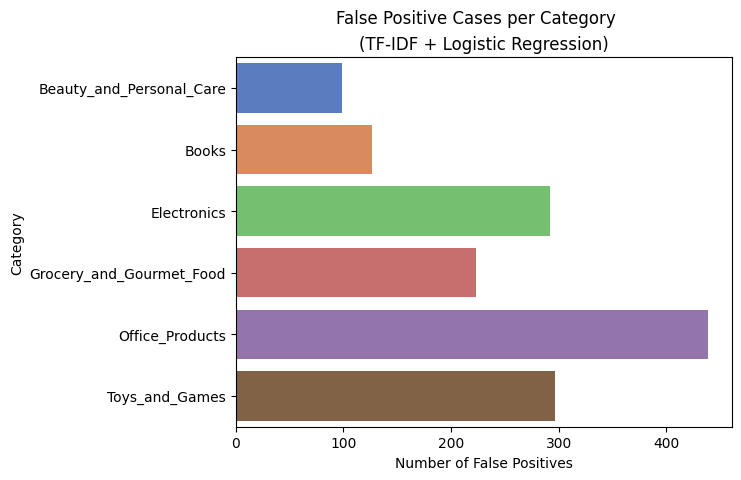

In [ ]:
false_positives = np.sum(cm, axis=0) - np.diag(cm)
labels = model.classes_

import seaborn as sns
sns.barplot(y=labels,
            x=false_positives, 
            palette="muted")

plt.suptitle("False Positive Cases per Category")
plt.title("(TF-IDF + Logistic Regression)")
plt.xlabel("Number of False Positives")
plt.ylabel("Category")
plt.legend([],[], frameon=False)



We see that Office_Products, Electronics, and Toys_and_Games have been mistakenly assigned to reviews the most.

# STEP 1.2: TF-IDF + Random Forest

Accuracy of Train Set: 0.86
Accuracy of Random Forest Model: 0.80


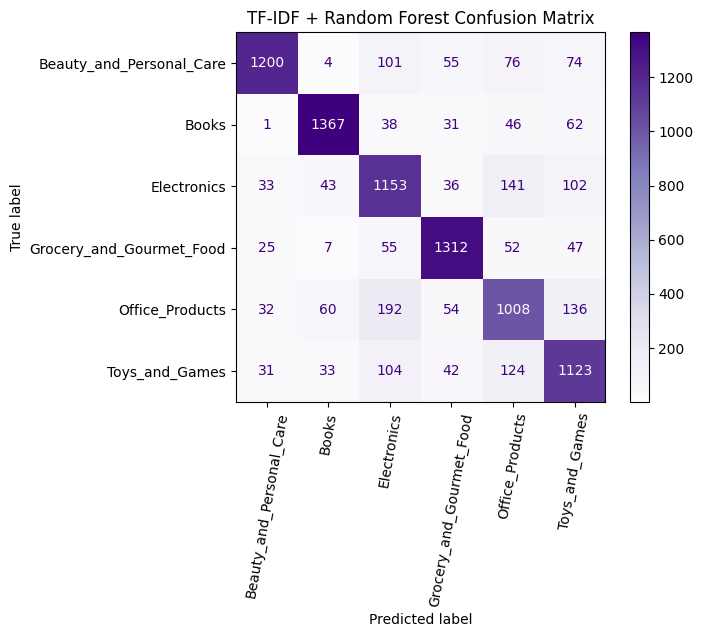

In [19]:
# Fit random forest Model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(min_samples_leaf=3,
                                  min_samples_split=10)
rf_model.fit(X_train, y_train)

y_test_df["random_forest"] = rf_model.predict(X_test)

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["random_forest"],
                      labels=np.unique(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)


import matplotlib.pyplot as plt
plt.title("TF-IDF + Random Forest Confusion Matrix")


# Accuracy

# Train Accuracy to check overfitting
y_train_pred = rf_model.predict(X_train)
accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)
print(f"Accuracy of Train Set: {accuracy_train:.2f}")

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["random_forest"])
print(f"Accuracy of Random Forest Model: {accuracy:.2f}")


new_data = pd.DataFrame([
                        {"model": "tf_idf_random_forest", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_random_forest", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)


## False Positive Cases 

/tmp/ipykernel_40430/755935879.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels,


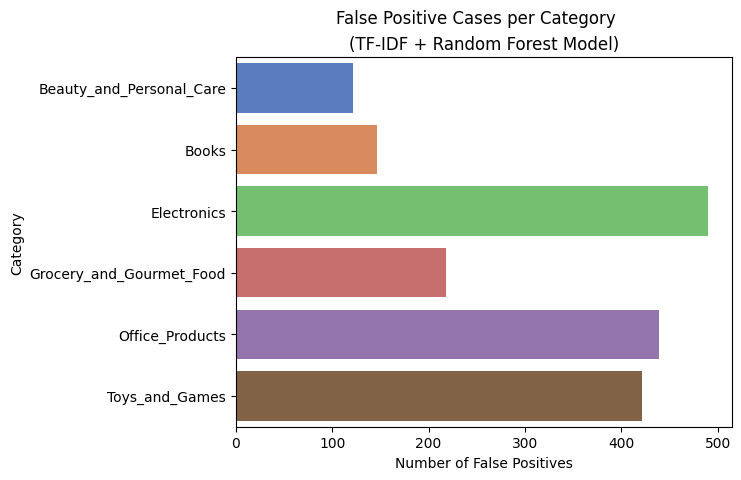

In [22]:
false_positives = np.sum(cm, axis=0) - np.diag(cm)
labels = rf_model.classes_

import seaborn as sns
sns.barplot(y=labels,
            x=false_positives, 
            palette="muted")

plt.suptitle("False Positive Cases per Category")
plt.title("(TF-IDF + Random Forest Model)")
plt.xlabel("Number of False Positives")
plt.ylabel("Category")
plt.legend([],[], frameon=False)



In [7]:
from sklearn.model_selection import train_test_split

X = reviews["text"]
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# STEP 2: Fine Tune LLM Model "distilbert-base-uncased"

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()

# Prediction and evaluation
predictions = trainer.predict(test_dataset_tokenized)

# Convert logits to predicted labels
y_pred_finetuned = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()



/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Map: 100%|██████████| 9000/9000 [00:01<00:00, 5799.68 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/

Epoch,Training Loss,Validation Loss
1,No log,0.436793
2,0.932100,0.379431
3,0.363700,0.372363


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train set Accuracy:0.94
Accuracy of Finetuned Bert LLM: 0.88


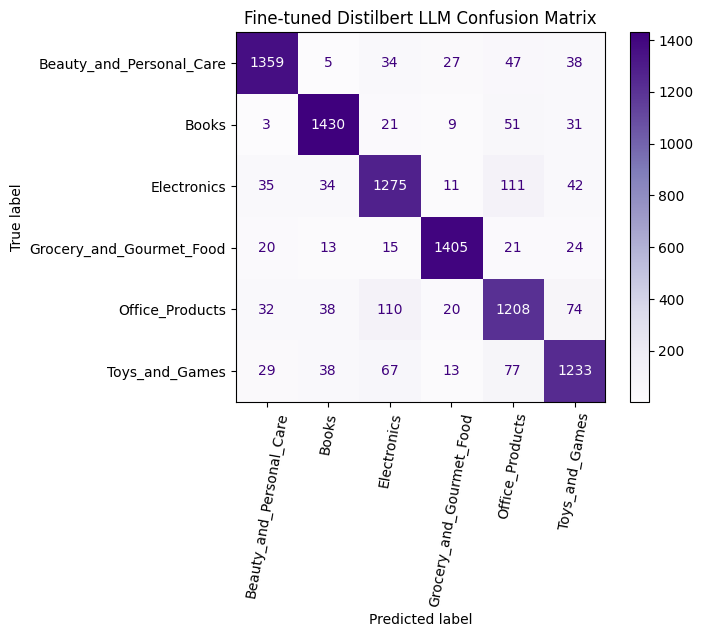

In [9]:
# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_test_df
y_test_df["finetuned_bert"] = [label_map_reverse[label] for label in y_pred_finetuned]

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


train_predictions = trainer.predict(train_dataset_tokenized)
y_pred_finetuned_train = torch.argmax(torch.tensor(train_predictions.predictions), dim=1).numpy()
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred_finetuned_train_num= [label_map_reverse[label] for label in y_pred_finetuned_train]

# Train Accuracy
train_accuracy =  accuracy_score(y_true=y_train,
                        y_pred=y_pred_finetuned_train_num)
print(f"Train set Accuracy:{train_accuracy:.2f}")


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["finetuned_bert"])
print(f"Accuracy of Finetuned Bert LLM: {accuracy:.2f}")


# Confusion Matrix
cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["finetuned_bert"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)


import matplotlib.pyplot as plt
plt.title("Fine-tuned Distilbert LLM Confusion Matrix")


new_data = pd.DataFrame([
                        {"model": "fine_tuned_distilbert_LLM", "set": "train", "accuracy": accuracy_train},
                         {"model": "fine_tuned_distilbert_LLM", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)

### False Positive Case

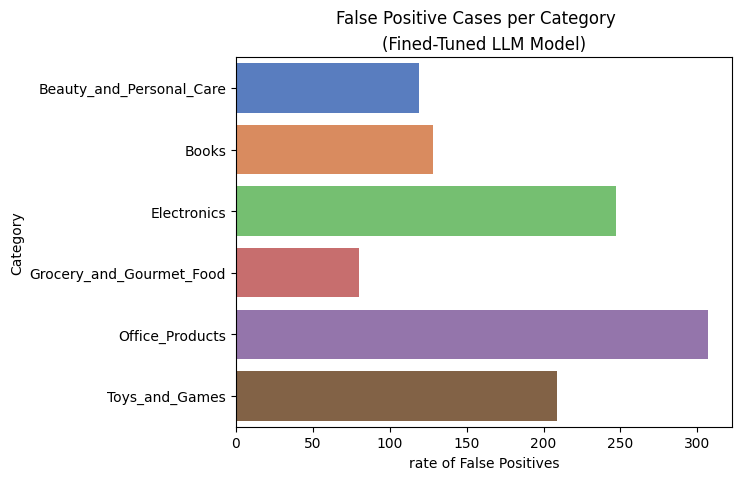

In [ ]:
false_positives = np.sum(cm, axis=0) - np.diag(cm)
labels = rf_model.classes_


import seaborn as sns
sns.barplot(y=nlabels,
            x=false_positives, 
            palette="muted")

plt.suptitle("False Positive Cases per Category")
plt.title("(Fined-Tuned LLM Model)")
plt.xlabel("rate of False Positives")
plt.ylabel("Category")
plt.legend([],[], frameon=False)

In [12]:
results_df = pd.DataFrame({"text": X_test})
results_df = pd.concat([results_df, y_test_df], axis=1)

for model in ["logistic_regression", "random_forest", "finetuned_bert"]:
    results_df[f"{model}_misclassified"] = results_df["true_value"] != results_df[model]


# STEP 3: Error Analysis

Analyze Misclassification by Length in fine-tuned model:


Text(0, 0.5, 'Length')

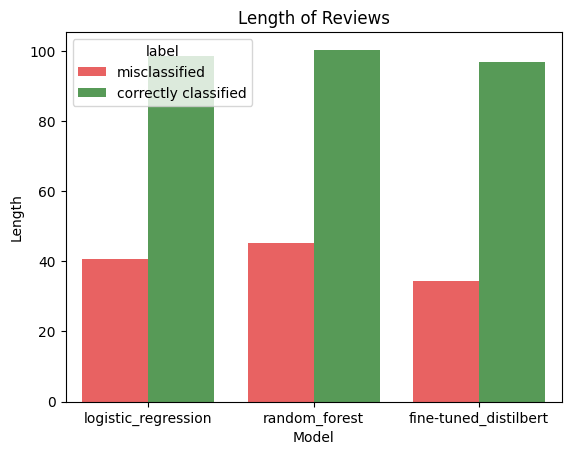

In [13]:
counts_df = pd.DataFrame(columns=["model", "misclassified", "correctly classified"])

def count_words(examples):
    return len(examples.split())

a = reviews["text"].apply(count_words).mean()



# Logistic Regression
b = results_df.loc[results_df["logistic_regression_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["logistic_regression_misclassified"], "text"].apply(count_words).mean()

new_counts = pd.DataFrame([{"model": "logistic_regression",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)



# Random Forest
b = results_df.loc[results_df["random_forest_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["random_forest_misclassified"], "text"].apply(count_words).mean()

new_counts = pd.DataFrame([{"model": "random_forest",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)




# Fined-tuned model
b = results_df.loc[results_df["finetuned_bert_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["finetuned_bert_misclassified"], "text"].apply(count_words).mean()


new_counts = pd.DataFrame([{"model": "fine-tuned_distilbert",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)


counts_df

counts_df_melt = counts_df.melt(id_vars="model", var_name="label", value_name="length")
sns.barplot(data=counts_df_melt,
            x="model",
            y="length",
            hue="label",
            palette=["red", "green"],
            alpha=0.7)


plt.title("Length of Reviews")

plt.xlabel("Model")
plt.ylabel("Length")

We can see that definitly the length of the review can have effect on probability of misclassification

In [151]:
pd.set_option('display.max_colwidth', None)


## STEP 3.2: undersample longer reviews for the train set

In [ ]:
from sklearn.model_selection import train_test_split

X = reviews["text"]
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [86]:
X_train_with_length = pd.DataFrame({"X_train":X_train,
                      "length": [count_words(x) for x in X_train]})

X_train_short_reviews = X_train_with_length[X_train_with_length["length"] < 40]
X_train_long_reviews = X_train_with_length[X_train_with_length["length"] >= 40]

X_train_long_undersampled = X_train_long_reviews.sample(frac=0.7, random_state=22, replace=False)

X_train_undersampled = pd.concat([X_train_long_undersampled, X_train_short_reviews], axis=0)["X_train"]

In [ ]:
# TF-IDF with logistic regression
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)

processed_texts = tfid.fit_transform(reviews["text"])

# Train-Test
from sklearn.model_selection import train_test_split

X = processed_texts
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

##### Undersample
X_train = X[X_train_undersampled.index]
y_train = y[X_train_undersampled.index]
#####

# Fit regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="multinomial", solver="saga",
                           penalty="elasticnet", l1_ratio=0.5, C=1)

model.fit(X_train, y_train)

y_test_df["logistic_regression_undersampled"] = model.predict(X_test)


# Accuracy

# Train Accuracy to check overfitting
y_train_pred = model.predict(X_train)

accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["logistic_regression"])


new_data = pd.DataFrame([
                        {"model": "tf_idf_logistic_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_logistic_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)

In [88]:
# TF-IDF fit random forest Model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(min_samples_leaf=3,
                                  min_samples_split=10)
rf_model.fit(X_train, y_train)

y_test_df["random_forest"] = rf_model.predict(X_test)



# Accuracy

# Train Accuracy to check overfitting
y_train_pred = rf_model.predict(X_train)

accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["random_forest"])


new_data = pd.DataFrame([
                        {"model": "tf_idf_random_forest_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_random_forest_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)


In [90]:
# Fine-tuned distilbert undersampled

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

#### Undersample
X = reviews["text"]
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

X_train = X_train_undersampled
y_train = y_train.loc[X_train_undersampled.index]
#### Undersample

df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()

# Prediction and evaluation
predictions = trainer.predict(test_dataset_tokenized)

# Convert logits to predicted labels
y_pred_finetuned = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()



Map: 100%|██████████| 9000/9000 [00:01<00:00, 5774.96 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/

Epoch,Training Loss,Validation Loss
1,No log,0.461467
2,0.969200,0.400797
3,0.368900,0.385046


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [91]:
# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_test_df
y_test_df["finetuned_bert"] = [label_map_reverse[label] for label in y_pred_finetuned]

# Metrics
from sklearn.metrics import accuracy_score


train_predictions = trainer.predict(train_dataset_tokenized)
y_pred_finetuned_train = torch.argmax(torch.tensor(train_predictions.predictions), dim=1).numpy()
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred_finetuned_train_num= [label_map_reverse[label] for label in y_pred_finetuned_train]

# Train Accuracy
train_accuracy =  accuracy_score(y_true=y_train,
                        y_pred=y_pred_finetuned_train_num)


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["finetuned_bert"])



new_data = pd.DataFrame([
                        {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)

In [92]:
accuracy_df["accuracy"] = accuracy_df["accuracy"].round(2)
accuracy_df

,model,set,accuracy
0,tf_idf_logistic_regression,train,0.87
1,tf_idf_logistic_regression,test,0.84
2,tf_idf_random_forest,train,0.86
3,tf_idf_random_forest,test,0.79
4,tf_idf_random_forest,train,0.86
5,tf_idf_random_forest,test,0.79
6,fine_tuned_distilbert_LLM,train,0.86
7,fine_tuned_distilbert_LLM,test,0.88
8,tf_idf_logistic_undersampled,train,0.86
9,tf_idf_logistic_undersampled,test,0.84


undersampling from the long reviews did not increase the accuracy much. But it did decrease the overfitting.

## STEP 3.2: Compare Errors by Category

In [15]:
misclassified_categories = results_df.groupby("true_value", as_index=False)[["logistic_regression_misclassified", "random_forest_misclassified", "finetuned_bert_misclassified"]].sum().sort_values("logistic_regression_misclassified")
misclassified_categories

,true_value,logistic_regression_misclassified,random_forest_misclassified,finetuned_bert_misclassified
3,Grocery_and_Gourmet_Food,136,188,93
1,Books,167,179,115
0,Beauty_and_Personal_Care,229,311,151
5,Toys_and_Games,285,334,224
2,Electronics,325,346,233
4,Office_Products,335,475,274


Text(0.5, 0, 'Misclassified Count')

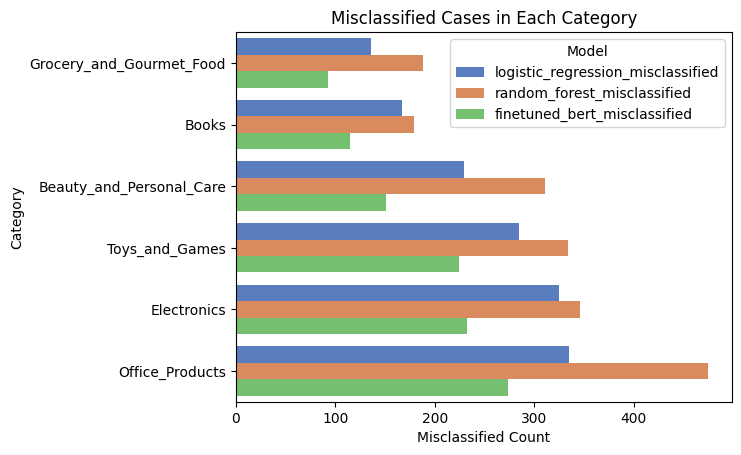

In [16]:
misclassified_melted = misclassified_categories.melt(id_vars="true_value", var_name="Model", value_name="Misclassified Count")

import seaborn as sns
sns.barplot(data=misclassified_melted,
            y="true_value",
            x="Misclassified Count",
            hue="Model",
            palette="muted")

plt.title("Misclassified Cases in Each Category")
plt.ylabel("Category")
plt.xlabel("Misclassified Count")


"Office_Products" and "Electronics" have the largest misclassified cases in all the models.


Let's dig into it:

For Office_Products and Electronics, first we will look at the cases which were misclassified in all the models.

## STEP 3.3: Compare model agreement

### Which cases have been misclassified in every model?

In [95]:
pd.set_option('display.max_colwidth', None)

'''
boolean_columns = ["logistic_regression_misclassified", 
                   "random_forest_misclassified", 
                   "zero_classification_misclassified", 
                   "finetuned_bert_misclassified"]'
'''
boolean_columns = ["logistic_regression_misclassified", 
                   "random_forest_misclassified", 
                   "finetuned_bert_misclassified"]

# indices of all the cases that have been misclassified in every model
bool_series = results_df[boolean_columns].all(axis=1)
idx_always_misclassified = bool_series[bool_series].index
always_misclassified = results_df.loc[idx_always_misclassified, "text"]

### Which words repeated the most in always misclassified cases?

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf.fit_transform(always_misclassified)

# Get feature names (words)
words = tfidf.get_feature_names_out()

# Sum up the TF-IDF scores for each word
word_tfidf_scores = X_tfidf.sum(axis=0).A1 

always_misclassified_word_frequency = pd.DataFrame({"word": words,
                                                    "score": word_tfidf_scores})

always_misclassified_word_frequency.sort_values("score", ascending=False).head(30)


,word,score
1310,good,32.985753
2371,product,30.235429
1347,great,29.247075
2374,productgood,26.573636
1801,love,18.832649
394,br,12.639408
2437,quality,12.540784
3359,use,12.437160
1741,like,11.930935
1284,gift,11.241901


Mostly too general words!

### Word Cloud for always misclassified cases

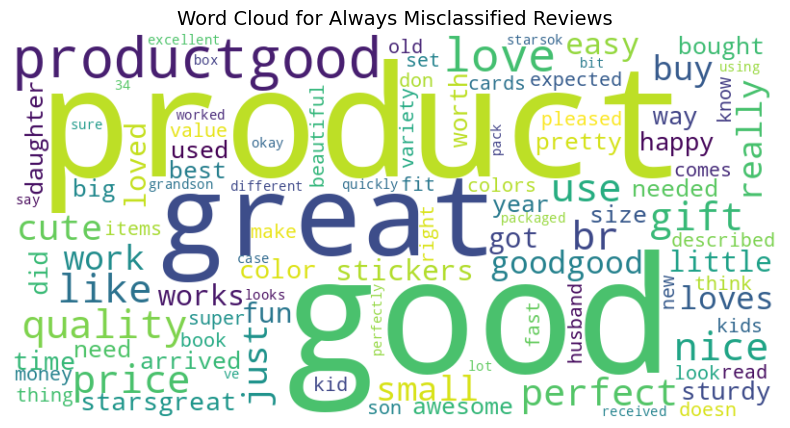

In [103]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df has two columns: 'word' and 'score'
word_score_data = dict(zip(always_misclassified_word_frequency["word"], always_misclassified_word_frequency["score"]))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis",
                      max_words=100).generate_from_frequencies(word_score_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud for Always Misclassified Reviews", fontsize=14)
plt.show()


In [38]:
np.mean([count_words(x) for x in results_df.loc[idx_always_misclassified, "text"]])


32.46984572230014

The average length of the reviews which were always misclassified is lower that the average length of all the reviews. 

Looking at the cases that have been misclassified by all the models, these are mainly reviews that are too general and do not specifically mention anything related to the product. They are often short reviews stating that the product was nice, good, bad, or broken without providing any further context. As a result, the models tend to randomly assign a category to them. <br>

We can remove the reviews that were consistently misclassified by every model, as these cases tend to be too broad, too short, or lack specific references to the product.

In [108]:
reviews_dropped_general = reviews.drop(idx_always_misclassified, axis=0)

In [114]:
# TF-IDF logistic regression
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)

processed_texts = tfid.fit_transform(reviews_dropped_general["text"])

# Train-Test
from sklearn.model_selection import train_test_split

X = processed_texts
y = reviews_dropped_general["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Fit regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="multinomial", solver="saga",
                           penalty="elasticnet", l1_ratio=0.5, C=1)

model.fit(X_train, y_train)
y_test_df = pd.DataFrame()
y_test_df["true_value"] = y_test

y_test_df["logistic_regression"] = model.predict(X_test)

# Metrics
# Accuracy
accuracy_df_dropped_general = pd.DataFrame(columns=["model", "set", "accuracy"])


# Train Accuracy to check overfitting
y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["logistic_regression"])



new_data = pd.DataFrame([
                        {"model": "tf_idf_logistic_regression", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_logistic_regression", "set": "test", "accuracy": accuracy}
                         ])

accuracy_df_dropped_general = pd.concat([accuracy_df_dropped_general, new_data], axis=0, ignore_index=True)


In [115]:
# Fine-tuned distilbert 

from sklearn.model_selection import train_test_split

X = reviews_dropped_general["text"]
y = reviews_dropped_general["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)



from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split


df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()

# Prediction and evaluation
predictions = trainer.predict(test_dataset_tokenized)

# Convert logits to predicted labels
y_pred_finetuned = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()


# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_test_df
y_test_df["finetuned_bert"] = [label_map_reverse[label] for label in y_pred_finetuned]

# Metrics
from sklearn.metrics import accuracy_score


train_predictions = trainer.predict(train_dataset_tokenized)
y_pred_finetuned_train = torch.argmax(torch.tensor(train_predictions.predictions), dim=1).numpy()
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred_finetuned_train_num= [label_map_reverse[label] for label in y_pred_finetuned_train]

# Train Accuracy
train_accuracy =  accuracy_score(y_true=y_train,
                        y_pred=y_pred_finetuned_train_num)


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["finetuned_bert"])



new_data = pd.DataFrame([
                        {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df_dropped_general = pd.concat([accuracy_df_dropped_general, new_data], axis=0, ignore_index=True)



Map: 100%|██████████| 8784/8784 [00:01<00:00, 5780.65 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/

Epoch,Training Loss,Validation Loss
1,No log,0.411864
2,0.894100,0.338946
3,0.298000,0.337157


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [116]:
accuracy_df_dropped_general

,model,set,accuracy
0,tf_idf_logistic_regression,train,0.892857
1,tf_idf_logistic_regression,test,0.846995
2,fine_tuned_distilbert_LLM_undersampled,train,0.892857
3,fine_tuned_distilbert_LLM_undersampled,test,0.893556


The TFIDF logistic regression model did not change much by removing the vague reviews but the LLM model improved both in train and test dataset.

### What are the average confidence scores of zero-shot classification in both successful and unsuccessful classifications?

In [ ]:
results_df.groupby("zero_classification_misclassified")["zero_shot_scores"].mean()

zero_classification_misclassified
False    0.667724
True     0.518112
Name: zero_shot_scores, dtype: float64

In [ ]:
pd.reset_option('display.max_colwidth')


In [119]:
reviews["category"].unique()

array(['Beauty_and_Personal_Care', 'Office_Products',
       'Grocery_and_Gourmet_Food', 'Books', 'Toys_and_Games',
       'Electronics'], dtype=object)

## Looking into Electronics category, Office_Products category and Grocery_and_Gourmet_Food category

Among all categories, Electronics and Office_Products have the highest number of false positive cases, while Grocery_and_Gourmet_Food consistently shows low false positives. This contrast makes them a good set for comparison when visualizing how mixed the categories appear after PCA transformation.

In [98]:
office_electronics = reviews[reviews["category"].isin(["Electronics", "Office_Products", "Grocery_and_Gourmet_Food"])]
office_electronics.head()

,text,category
1,"Sturdy!These are sturdy, poly plastic folder/d...",Office_Products
3,"Great value, big box.This 58 count box is such...",Grocery_and_Gourmet_Food
6,Simply HeinzI didn't realize that I could stil...,Grocery_and_Gourmet_Food
9,Decadently wonderful Caramel!Walkers makes sup...,Grocery_and_Gourmet_Food
10,Big cupsVery good,Grocery_and_Gourmet_Food


## PCA for TF-IDF features

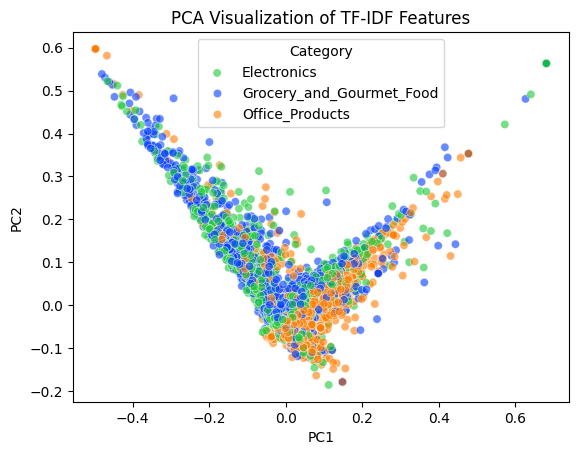

In [21]:
from sklearn.model_selection import train_test_split
X = office_electronics["text"]
y = office_electronics["category"]



# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)
processed_X = tfid.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(processed_X.toarray(), y, test_size=0.3, random_state=22)


# Convert labels to numeric 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)


# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

X_pca = pca.fit_transform(X=X_train)


pca_df = pd.DataFrame({"PC1": X_pca[:, 0],
                       "PC2": X_pca[:, 1],
                       "label": y_train_num})

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"],
                hue=pca_df["label"], alpha=0.6, palette="bright")

plt.title("PCA Visualization of TF-IDF Features")

plt.xlabel("PC1")
plt.ylabel("PC2")
#plt.legend(["Electronics", "Office_Products", "Grocery_and_Gourmet_Food"])
# Automatically get correct category names from LabelEncoder
category_names = le.inverse_transform(sorted(pca_df["label"].unique()))
plt.legend(title="Category", labels=category_names)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver="saga",
                        penalty="elasticnet", multi_class="multinomial",
                        l1_ratio=0.5)

lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
y_lr_pred_train = lr.predict(X_train)

accuracy_df = pd.DataFrame([{"model": "TFIDF + Linear Regression",
                            "accuracy": accuracy_score(y_true=y_test,y_pred=y_lr_pred), 
                            "set": "test"},
                            {"model": "TFIDF + Linear Regression",
                            "accuracy": accuracy_score(y_true=y_train,y_pred=y_lr_pred_train), 
                            "set": "train"}])

accuracy_df


,model,accuracy,set
0,TFIDF + Linear Regression,0.864889,test
1,TFIDF + Linear Regression,0.912571,train


In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.01022604, 0.0191861 , 0.02701969, 0.03282252, 0.03826396])

The plot above doesn't show any separation between two categories using PCs. TF-IDF data is very sparse and most of the cells are 0, therefore PCA is not a good option for TF-IDF data. We can try t-SNE instead.

## TSNE for TF-IDF features

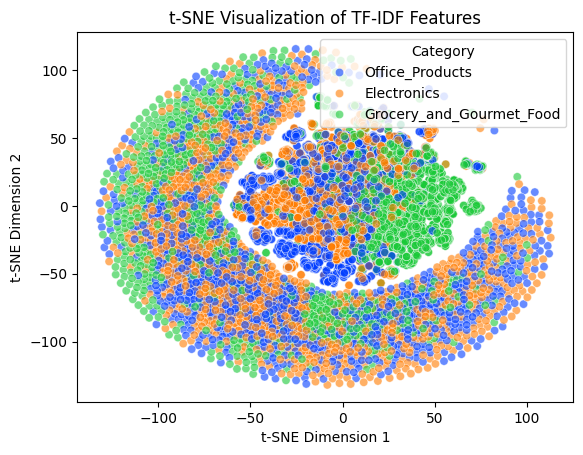

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE


X = office_electronics["text"]
y = office_electronics["category"]

# TF-IDF
tfid = TfidfVectorizer(stop_words="english", 
                       max_features=10000,
                       min_df=0.01,  # term must appear in at least 1% of documents
                       max_df=0.99   # term must appear in no more than 99% of documents
                       )
processed_X = tfid.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(processed_X.toarray(), y, test_size=0.3, random_state=22)



tsne = TSNE(n_components=2, random_state=22, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_train)

tsne_df = pd.DataFrame({
    "Dim1": X_tsne[:, 0],
    "Dim2": X_tsne[:, 1],
    "category": y_train
})

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="Dim1", y="Dim2", hue="category", data=tsne_df, palette="bright", alpha=0.6)
plt.title("t-SNE Visualization of TF-IDF Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.legend(title="Category")



Although the points are quite mixed, we can observe some green clusters representing Grocery_and_Gourmet_Food, while the blue and orange dots, corresponding to the other two categories, are heavily mixed and not clearly distinguishable.

## PCA and t-SNE for fine-tuned LLM embeddings

In [ ]:
from sklearn.model_selection import train_test_split

X = office_electronics["text"]
y = office_electronics["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)


from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})


# KEEP IN MIND THAT THIS WAY OF ENCODING IS ORDER DEPENDENT AND IF TRAIN SET CHANGES THIS WILL NOT STAY THE SAME
# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()



# Save Model
trainer.save_model("finetuned_model/")


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 4500/4500 [00:00<00:00, 6028.33 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, a

Epoch,Training Loss,Validation Loss
1,No log,0.291026
2,No log,0.245727
3,0.404400,0.254533


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [14]:
from sklearn.model_selection import train_test_split

X = office_electronics["text"]
y = office_electronics["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)



import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained("finetuned_model/").to(device)
embedding_model.eval()

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Batching
batch_size = 32
all_embeddings = []

for i in range(0, len(X_train), batch_size):
    batch_texts = list(X_train[i:i+batch_size])
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = embedding_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)

# Combine batches into full array
train_embeddings = np.vstack(all_embeddings)
print("Embedding shape:", train_embeddings.shape)


Embedding shape: (10500, 768)


This block is for predicting labels using LLM

In [100]:
from sklearn.model_selection import train_test_split

X = office_electronics["text"]
y = office_electronics["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)


from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})


# KEEP IN MIND THAT THIS WAY OF ENCODING IS ORDER DEPENDENT AND IF TRAIN SET CHANGES THIS WILL NOT STAY THE SAME
# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")





############
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("finetuned_model/").to(device)

trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset_tokenized)
predictions_train = trainer.predict(train_dataset_tokenized)


# Convert logits to predicted labels
y_pred= torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_pred_train= torch.argmax(torch.tensor(predictions_train.predictions), dim=1).numpy()


# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred = [label_map_reverse[label] for label in y_pred]
y_pred_train = [label_map_reverse[label] for label in y_pred_train]


Map: 100%|██████████| 4500/4500 [00:00<00:00, 5840.38 examples/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [23]:
new_data = pd.DataFrame([{"model": "LLM",
                            "accuracy": accuracy_score(y_true=y_test,y_pred=y_pred), 
                            "set": "test"},
                            {"model": "LLM",
                            "accuracy": accuracy_score(y_true=y_train,y_pred=y_pred_train), 
                            "set": "train"}])

accuracy_df = pd.concat([accuracy_df, new_data])
accuracy_df

,model,accuracy,set
0,TFIDF + Linear Regression,0.864889,test
1,TFIDF + Linear Regression,0.912571,train
0,LLM,0.903556,test
1,LLM,0.964762,train


In [7]:
le.classes_

array(['Electronics', 'Grocery_and_Gourmet_Food', 'Office_Products'],
      dtype=object)

## PCA for LLM

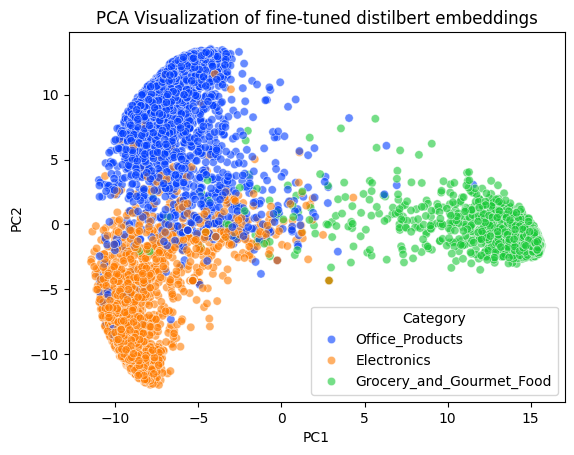

In [8]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_embeddings)



pca_df = pd.DataFrame({"PC1": X_pca[:, 0],
                       "PC2": X_pca[:, 1],
                       "category": y_train})


import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x="PC1", y="PC2", data=pca_df,
                hue="category", palette="bright", alpha=0.6)

plt.title("PCA Visualization of fine-tuned distilbert embeddings")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Category")

## t-SNE for LLM

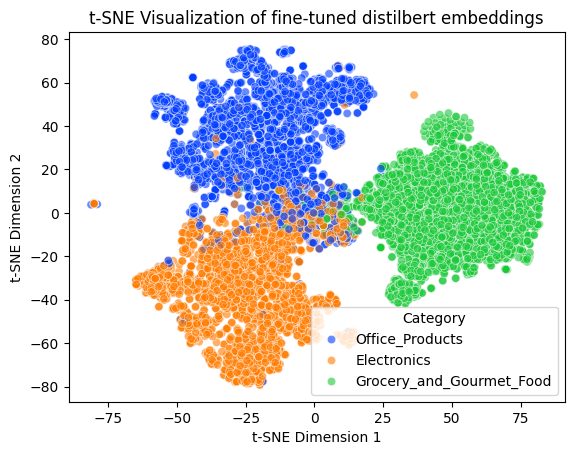

In [8]:
# TSNE
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=22, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(train_embeddings)


tsne_df = pd.DataFrame({
    "Dim1": X_tsne[:, 0],
    "Dim2": X_tsne[:, 1],
    "category": y_train
})

sns.scatterplot(x="Dim1", y="Dim2", hue="category", data=tsne_df, palette="bright", alpha=0.6)
plt.title("t-SNE Visualization of fine-tuned distilbert embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.legend(title="Category")

### Cosine Similarity between average embeddings of "Office_Products" and "Electronics"

In [18]:
office_average = train_embeddings[y_train == "Office_Products"].mean(axis=0)
electronics_average = train_embeddings[y_train == "Electronics"].mean(axis=0)


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# find similarity between TFIDF train set and LLM embedding for train set
sim = cosine_similarity([office_average], [electronics_average])
sim


array([[0.24556664]], dtype=float32)

## Measure uncertainty using Monte Carlo dropout

In [4]:
# Enable dropout at test time
def enable_mc_dropout(model):
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()


import torch
import numpy as np

def predict_with_uncertainty(model, inputs, n_iter=20):
    model.eval()
    enable_mc_dropout(model)
    
    all_logits = []

    for _ in range(n_iter):
        with torch.no_grad():
            outputs = model(**inputs)
            all_logits.append(outputs.logits.cpu().numpy())

    # Shape: (n_iter, batch_size, num_classes)
    logits_stack = np.stack(all_logits)
    
    # Mean prediction
    probs_mean = torch.nn.functional.softmax(torch.tensor(logits_stack), dim=-1).mean(dim=0).numpy()
    
    # Predictive entropy
    entropy = -np.sum(probs_mean * np.log(probs_mean + 1e-10), axis=1)

    return probs_mean, entropy


from transformers import AutoModelForSequenceClassification

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModelForSequenceClassification.from_pretrained("finetuned_model/").to(device)
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Batching
batch_size = 32
all_mean = []
all_entropies = []

for i in range(0, len(X_train), batch_size):
    batch_texts = list(X_train[i:i+batch_size])
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    

    mean_prediction, entropies = predict_with_uncertainty(embedding_model, inputs)

    all_mean.append(mean_prediction)
    all_entropies.append(entropies)

        

# Combine batches into full array
train_mean = np.vstack(all_mean)
train_entropy = np.concatenate(all_entropies)

In [30]:
np.save("train_mean_MCdropout.npy", train_mean)
np.save("train_entropy_MCdropout.npy", train_entropy)

In [6]:
#np.load("train_mean_MCdropout.npy")
#np.load("train_entropy_MCdropout.npy")

array([0.05830171, 0.09097717, 0.10576678, ..., 0.022447  , 0.06428446,
       0.11868738], dtype=float32)

In [109]:
# MC dropout model predictions
y_train_MCdropout_pred = np.argmax(train_mean, axis=1)


# Convert the labels back to category names
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

label_map_reverse = {v: k for k, v in label_map.items()}
y_train_df = pd.DataFrame({"category": y_train})

y_train_df["MCdropout_LLM"] = [label_map_reverse[label] for label in y_train_MCdropout_pred]

y_train_df["entropy"] = train_entropy

misclassified_idx = y_train_df[y_train_df["category"] != y_train_df["MCdropout_LLM"]].index
correctly_classified_idx = y_train_df[y_train_df["category"] == y_train_df["MCdropout_LLM"]].index

y_train_df

,category,MCdropout_LLM,entropy
26058,Office_Products,Office_Products,0.058302
1785,Electronics,Electronics,0.090977
4869,Office_Products,Office_Products,0.105767
27854,Electronics,Electronics,0.059731
19610,Office_Products,Office_Products,0.060855
...,...,...,...
10960,Electronics,Electronics,0.242766
17198,Electronics,Electronics,0.058099
26232,Grocery_and_Gourmet_Food,Grocery_and_Gourmet_Food,0.022447
12617,Electronics,Electronics,0.064284


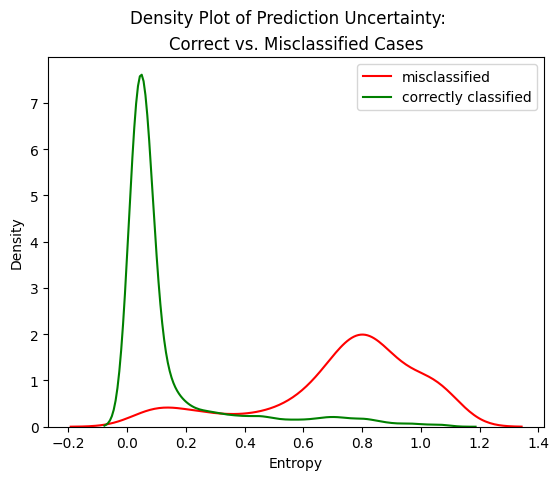

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data=y_train_df.loc[misclassified_idx, :], x="entropy", color="red", label="misclassified")
sns.kdeplot(data=y_train_df.loc[correctly_classified_idx, :], x="entropy", color="green", label="correctly classified")

plt.suptitle("Density Plot of Prediction Uncertainty:")
plt.title("Correct vs. Misclassified Cases")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()

Very interesting to see that the uncertainty of the model in classifying the misclassified cases is on average higher than the correct cases.

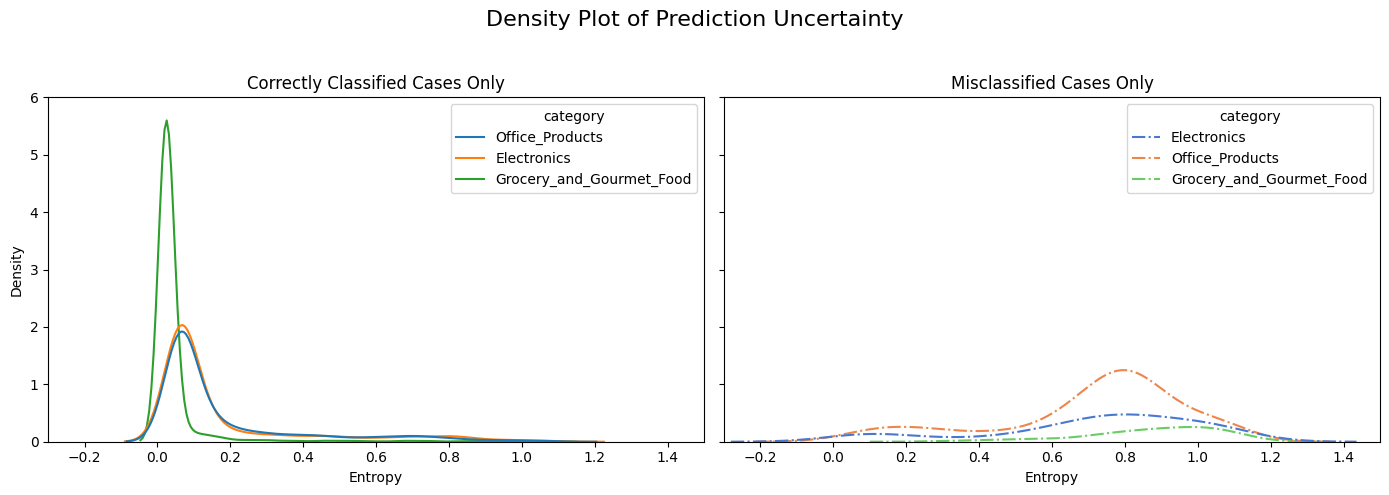

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.kdeplot(data=y_train_df.loc[correctly_classified_idx, :], 
            x="entropy", 
            hue="category",
            ax=axes[0])

axes[0].set_title("Correctly Classified Cases Only")
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Density")  
axes[0].set_xlim([-0.3, 1.5])
axes[0].set_ylim([0, 6])


sns.kdeplot(data=y_train_df.loc[misclassified_idx, :], 
            x="entropy", 
            hue="category", palette="muted",
            linestyle="-.",
            ax=axes[1])
axes[1].set_title("Misclassified Cases Only")
axes[1].set_xlabel("Entropy")
axes[1].set_ylabel("Density")
axes[1].set_xlim([-0.3, 1.5])
axes[1].set_ylim([0, 6])





fig.suptitle("Density Plot of Prediction Uncertainty", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


    

Not a lot of similarity. Suprprising

## Most Frequent Words in TFIDF for Electronics vs. Office Products

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE


X = office_electronics["text"]
y = office_electronics["category"]


# TF-IDF for Electronics label
X_electronics = X[y == "Electronics"]

tfid_electronics = TfidfVectorizer(stop_words="english", max_features=10000)
X_electronics_tfidf = tfid_electronics.fit_transform(X_electronics)
words_electronics = tfid_electronics.get_feature_names_out()

tfidf_scores_office = X_electronics_tfidf.sum(axis=0).A1

tfidf_electronics_df = pd.DataFrame({"word_electronics": words_electronics,
                                "score": tfidf_scores_office})

# TF-IDF for Office products label
X_office = X[y == "Office_Products"]

tfid_office = TfidfVectorizer(stop_words="english", max_features=10000)
X_office_tfidf = tfid_office.fit_transform(X_office)
words_office = tfid_office.get_feature_names_out()

tfidf_scores_office = X_office_tfidf.sum(axis=0).A1

tfidf_office_df = pd.DataFrame({"word_office": words_office,
                                "score": tfidf_scores_office})


print(tfidf_office_df.sort_values("score", ascending=False).head(10))
print(tfidf_electronics_df.sort_values("score", ascending=False).head(10))



     word_office       score
4052       great  184.217666
1600          br  165.806741
3939        good  143.340631
9219         use  109.019657
5516        nice  106.094282
5115        love  102.327802
6331     quality   92.517462
5026        like   91.997273
4814        just   85.861315
6225     product   83.766911
     word_electronics       score
1760               br  215.934355
3929            great  198.981981
3878             good  146.360643
9768            works  112.997683
6108          product  105.958468
9203              use  102.966759
4783             like   92.590443
4884             love   90.995557
6247          quality   88.470984
3144             easy   87.813319


Most frequent words are similar and cannot get anything from it

## Logistic Regression on Office_Products and Electronics

In [79]:
X_office_electronics = X [y != "Grocery_and_Gourmet_Food"]
y_office_electronics = y[y != "Grocery_and_Gourmet_Food"]

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_electronics = TfidfVectorizer(stop_words="english", max_features=10000)
X_office_electronics_tfidf = tfid_electronics.fit_transform(X_office_electronics)

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_office_electronics_tfidf, y_office_electronics, test_size=0.3, random_state=22)

# Fit Model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(multi_class="multinomial", solver="saga",
                                    penalty="elasticnet", l1_ratio=0.5, C=1)

logistic_model.fit(X=X_train, y=y_train)

y_test_pred = logistic_model.predict(X_test)

# Metrics
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
accuracy

0.8566666666666667

## Topic Modeling Latent Dirichlet Allocation

In [60]:
# Reset Index
office_electronics.reset_index(inplace=True, drop=True)

In [99]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


nltk.download('punkt')
nltk.download('stopwords')

# Preprocess text
def preprocess(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Tokenize reviews
tokenized_reviews = [preprocess(review) for review in office_electronics["text"]]

# Build dictionary and corpus
dictionary = Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Run LDA
lda_model = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary, passes=10)
lda_model.print_topics()

[nltk_data] Downloading package punkt to /home/mi130176/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mi130176/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0,
  '0.015*"good" + 0.014*"like" + 0.009*"flavor" + 0.009*"great" + 0.009*"taste" + 0.007*"love" + 0.007*"would" + 0.006*"reviews" + 0.006*"one" + 0.006*"really"'),
 (1,
  '0.023*"great" + 0.013*"good" + 0.012*"love" + 0.009*"quality" + 0.008*"nice" + 0.008*"cards" + 0.008*"card" + 0.008*"gift" + 0.007*"well" + 0.007*"one"'),
 (2,
  '0.040*"br" + 0.009*"use" + 0.008*"one" + 0.007*"great" + 0.006*"easy" + 0.006*"like" + 0.005*"would" + 0.005*"work" + 0.005*"good" + 0.005*"well"')]

Text(0, 0.5, 'Number of Reviews')

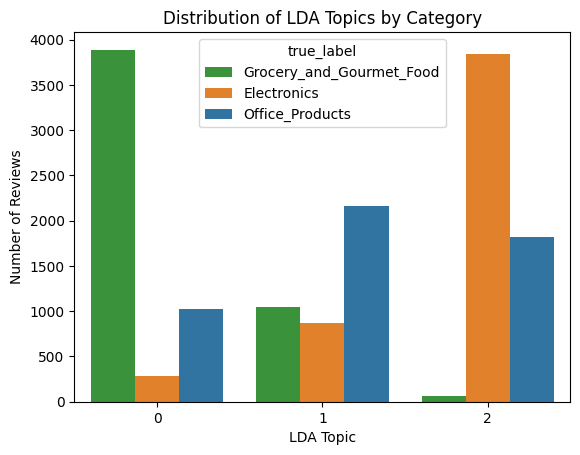

In [103]:
all_reviews_prob = [lda_model.get_document_topics(doc) for doc in corpus]
dominant_topics = [max(doc, key=lambda x: x[1])[0] for doc in all_reviews_prob]

lda_df = pd.DataFrame({"text": office_electronics["text"],
                       "true_label": office_electronics["category"],
                       "lda_topic": dominant_topics})

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="lda_topic", data=lda_df,
              hue="true_label", palette=["#2ca02c", "#ff7f0e", "#1f77b4" ])

plt.title("Distribution of LDA Topics by Category")
plt.xlabel("LDA Topic")
plt.ylabel("Number of Reviews")


We see that LDA topic 0 primarily corresponds to "Office_Products", topic 2 aligns with "Grocery_and_Gourmet_Food", and topic 1 aligns with "Electronics". However, there is some overlap—for example, topic 0 includes a small number of "Electronics" reviews, and topic 2 contains a few "Office_Products" reviews. This may be due to cases where the topic probabilities were very close, and selecting the topic with the highest probability (argmax) led to slight misalignment.

In [104]:
missclassified_index = np.where(y_train.reset_index(drop=True) != y_pred_train)[0]

Text(0, 0.5, 'Number of Reviews')

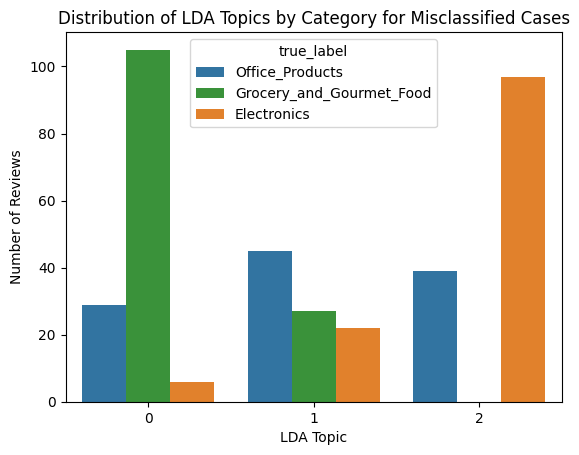

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="lda_topic", data=lda_df.loc[missclassified_index,],
              hue="true_label", palette=["#1f77b4" , "#2ca02c", "#ff7f0e"])

plt.title("Distribution of LDA Topics by Category for Misclassified Cases")
plt.xlabel("LDA Topic")
plt.ylabel("Number of Reviews")


### If we want to compare LDA topics with the true labels for accuracy

In [ ]:
office_electronics_idx = reviews[reviews["category"].isin(["Electronics", "Office_Products", "Grocery_and_Gourmet_Food"])].index
office_electronics_idx

lda_df_original_idx = lda_df.set_index(office_electronics_idx)
lda_df_original_idx

lda_topic_map = {0: "Office_Products",
                 1: "Grocery_and_Gourmet_Food",
                 2: "Electronics"}

lda_df_original_idx["lda_topic"] = lda_df_original_idx["lda_topic"].map(lda_topic_map)

accuracy_test_lda = (lda_df_original_idx.loc[y_test.index, "category"] == lda_df_original_idx.loc[y_test.index,"lda_topic"]).mean()
accuracy_train_lda = (lda_df_original_idx.loc[y_train.index, "category"] == lda_df_original_idx.loc[y_train.index,"lda_topic"]).mean()


new_data = pd.DataFrame([{"model": "LDA", "accuracy": accuracy_test_lda, "set": "test"},
                         {"model": "LDA", "accuracy": accuracy_train_lda, "set": "train"}])
pd.concat([accuracy_df, new_data])

### Take a look at labels in topic 0

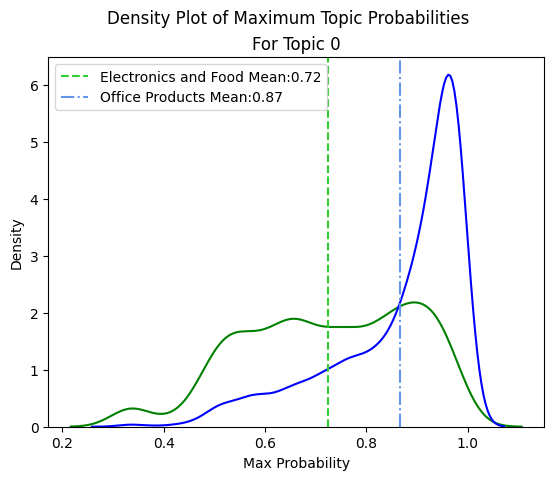

In [163]:
topic_0_minority = lda_df[(lda_df["lda_topic"] == 0) & (lda_df["category"] != "Office_Products")]
topic_0_majority = lda_df[(lda_df["lda_topic"] == 0) & (lda_df["category"] == "Office_Products")]

topic_0_minority_probabilities = np.array(all_reviews_prob, dtype=object)[topic_0_minority.index]
max_probs_distribution_minority = [max(doc, key=lambda x: x[1])[1] for doc in topic_0_minority_probabilities]

topic_0_majority_probabilities = np.array(all_reviews_prob, dtype=object)[topic_0_majority.index]
max_probs_distribution_majority = [max(doc, key=lambda x: x[1])[1] for doc in topic_0_majority_probabilities]

import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(max_probs_distribution_minority, color="green")

sns.kdeplot(max_probs_distribution_majority, color="blue")


plt.suptitle("Density Plot of Maximum Topic Probabilities")
plt.title("For Topic 0")
plt.xlabel("Max Probability")
plt.ylabel("Density")

# Plot the average
mean_prob_minority = np.mean(max_probs_distribution_minority)
plt.axvline(mean_prob_minority, color="limegreen", linestyle="--", label=f"Electronics and Food Mean:{mean_prob_minority:.2f}")

mean_prob_majority = np.mean(max_probs_distribution_majority)
plt.axvline(mean_prob_majority, color="cornflowerblue", linestyle="-.", label=f"Office Products Mean:{mean_prob_majority:.2f}")

plt.legend()


I found it interesting that when topic modeling assigned topic 0 as the most probable topic for certain reviews, the model was, on average, more confident in cases labeled as "Office_Products" compared to those labeled as "Electronics" or "Grocery_and_Gourmet_Food". <br>
Also the distribution of maximum topic probabilities for "Office_Products" is left-skewed, with a peak near 1. In contrast, the distributions for "Electronics" and "Grocery_and_Gourmet_Food" are more uniform, ranging between 0.5 and 0.8.

## Attention

In [99]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from bertviz import head_view
import torch

model_name = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)

# Example sentence
sentence = "The keyboard works great with my new monitor."


# Tokenize
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Extract attention and tokens
attention = outputs.attentions  # List of tensors, one per layer
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

head_view(attention, tokens)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

### Misclassified cases

In [116]:
o_e_result = pd.DataFrame({"category": y_train,
                           "LLM_prediction": y_pred_train})
o_e_result = o_e_result[o_e_result["category"] != "Grocery_and_Gourmet_Food"]

In [117]:
misclassified_idx_o_e = o_e_result[o_e_result["category"] != o_e_result["LLM_prediction"]].index

## Visualization for Attention weights for misclassified cases

/tmp/ipykernel_105164/3495121093.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


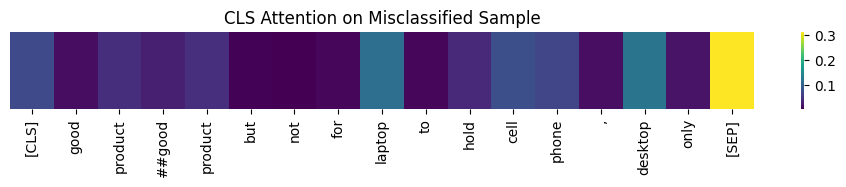

text        Good productGood product but not for laptop to hold cell phone, desktop only
category                                                                 Office_Products
Name: 24481, dtype: object


In [135]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("finetuned_model/").to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Pick a misclassified example
misclassified_i = 24481
text = office_electronics.loc[misclassified_i, "text"]

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass with attention output
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # list of attention layers
    last_layer_cls_attn = attentions[-1][:, :, 0, :]  # shape: (1, heads, seq_len)
    avg_cls_attn = last_layer_cls_attn.mean(dim=1)[0]  # shape: (seq_len,)

# Convert to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Plot attention
plt.figure(figsize=(12, 1))
sns.heatmap(avg_cls_attn.cpu().numpy()[np.newaxis, :], 
            xticklabels=tokens, cmap="viridis", cbar=True)
plt.xticks(rotation=90)
plt.yticks([])
plt.title("CLS Attention on Misclassified Sample")
plt.tight_layout()
plt.show()

pd.set_option('display.max_colwidth', None)  # Show full content in columns

print(office_electronics.loc[misclassified_i])


In [134]:
o_e_result.loc[24481]

category          Office_Products
LLM_prediction        Electronics
Name: 24481, dtype: object

In [133]:
office_electronics.loc[misclassified_idx_o_e].tail(20)

,text,category
5594,THESE ARE GIFTSI LOVE MINE AND SO I BOUGHT 2 MORE..,Electronics
11956,NiceGood for the price,Electronics
20597,"Heavy....I'm very very happy with this, it is much better than the picture . Great price Great product , it is much more than I expected. Thank you",Office_Products
17672,Good ProductGood Product,Office_Products
4719,Good ProductGood Product,Office_Products
24215,Not worth itI didnt get this product I need up with a regular ballpoint pen.,Electronics
20096,Good ProductGood Product,Office_Products
24481,"Good productGood product but not for laptop to hold cell phone, desktop only",Office_Products
10411,"don't waste your moneyvery poor quality… as I try to wipe the excess fluid off and it just ripped. I put on the second piece, wiped very gently, check it the next morning, the edge has shriveled. It dried and curl up at the edge!!",Electronics
15178,StrongI used them on my shoes to help them stay on.,Electronics


## Visualization for Attention weights for correctly classified cases

/tmp/ipykernel_105164/4137939664.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


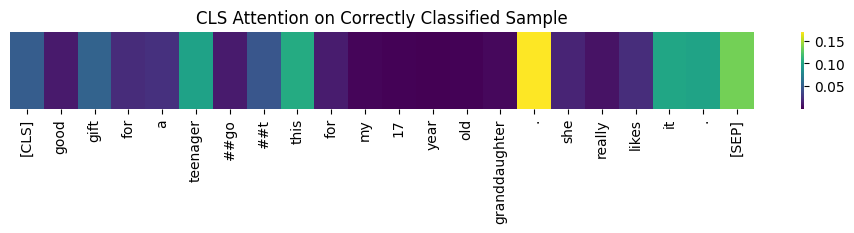

text        GOOD GIFT FOR A TEENAGERGot this for my 17 year old granddaughter.  She really likes it.
category                                                                                 Electronics
Name: 337, dtype: object


In [178]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("finetuned_model/").to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Pick a misclassified example
correctly_classified_i = 337
text = office_electronics.loc[correctly_classified_i, "text"]

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass with attention output
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # list of attention layers
    last_layer_cls_attn = attentions[-1][:, :, 0, :]  # shape: (1, heads, seq_len)
    avg_cls_attn = last_layer_cls_attn.mean(dim=1)[0]  # shape: (seq_len,)

# Convert to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Plot attention
plt.figure(figsize=(12, 1))
sns.heatmap(avg_cls_attn.cpu().numpy()[np.newaxis, :], 
            xticklabels=tokens, cmap="viridis", cbar=True)
plt.xticks(rotation=90)
plt.yticks([])
plt.title("CLS Attention on Correctly Classified Sample")
plt.tight_layout()
plt.show()


print(office_electronics.loc[correctly_classified_i])


In [170]:
o_e_result.iloc[50:60]

,category,LLM_prediction
13597,Office_Products,Electronics
29407,Office_Products,Office_Products
2422,Office_Products,Office_Products
13182,Electronics,Electronics
8758,Electronics,Electronics
2942,Electronics,Electronics
27224,Electronics,Electronics
19216,Office_Products,Office_Products
15748,Office_Products,Office_Products
22193,Office_Products,Office_Products


In [177]:
office_electronics.iloc[150:200]

,text,category
327,"Cleaned the screens on all my devicesI purchased myself a new Kindle during Black Friday sales on Amazon. Almost immediately I noticed fingerprints all over the screen. I found this cleaner and wanted to try it . I will say, it did clean the face of the Kindle well, got rid of the fingerprints. I love the cleaning cloth that it comes with. I also tried this on my laptop and it also worked well. I wish this came in a smaller size so I could carry it in my purse (they should have included a small bottle that you could refill for portability). Outside of that, for the money you can't do better.",Electronics
331,"Great cableMy son asked for this for his computer. I can't really explain what it's for, but he's happy with it, and he's hard to please, so that's why I said it's a great cable.",Electronics
334,"Great Noise Canceling!My husband enjoys listening to podcasts when mowing the lawn. He was very impressed with the noise canceling capabilities of these headphones. It was then that he realized that his previous headphones didn't have that feature. He said he they blocked out nearly all the sounds of the lawn mower. It also blocked out my voice when I called to him when usually he can hear me after a moment or so. These are light weight and comfortable to wear. It was simple to pair with his phone. He has had other Bluetooth headphones before, but these have been his favorite pair. The sound quality is good - though he tends to listen to podcasts rather than music with headphones.",Electronics
335,Good care package. Would gift again.Care package for senior. He loved it and the selection.,Grocery_and_Gourmet_Food
336,Tapevconstantly broke and then you would have to find the ...Tapevconstantly broke and then you would have to find the broken end would just had stuck to the row to start over it. I think the tape was too thin,Office_Products
337,GOOD GIFT FOR A TEENAGERGot this for my 17 year old granddaughter. She really likes it.,Electronics
340,"Try it,,medium is tasty!Purchased at HEB in Texas,,,the medium is delicious!<br />We love it and serve with chips but also tastes great mixed<br />with some ranch dip as a salsa ranch dressing.<br /> We like it on scrambled eggs , grilled cheese<br />as well as grilled chicken.",Grocery_and_Gourmet_Food
341,"Works great for our whiteboards.We use three out of the four markers right now, and will use the other once one of those runs out. We have two whiteboards on our fridge--a calendar and one general notepad--and I have a larger one in my office which I use to take notes for my writing.<br /><br />I prefer the fine tip because I have tiny handwriting as it is, and it leaves me with far more space to use on the board. The price is right too.<br />I would make these better by having an eraser on the cap of each marker, but that would probably raise the price.<br /><br />All in all, a good set of whiteboard markers.",Office_Products
346,AWESOME !! wow !!OMG what a HUGEEEE roll i didnt realize it was SOOOooooo BIG very PLEASED !!,Office_Products
347,"Not bad, but I have had betterNot overly thrilled with these. Flavor was good (as well as the ingredients) but they were overly dry and I found myself having to drink something with them to make them go down right. Not sure if they were overly stale or if they are all like this consistency. But, they are gluten and dairy free and vegan and high in protein. Maybe it was just a bad batch that I received?",Grocery_and_Gourmet_Food
